In [104]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple


In [71]:
path_to_recall_reports = "../cluster/analysis/recall/reports"
all_100x_with_denovo_recall_reports = list(Path(path_to_recall_reports).glob("*/100x/*with_denovo*/*.tsv"))
all_100x_no_denovo_recall_reports = list(Path(path_to_recall_reports).glob("*/100x/*no_denovo*/*.tsv"))


In [75]:
def get_gene_classification_df(report_file):
    recall_report = pd.read_csv(report_file, sep="\t", dtype={"ref_probe_header": str, "classification": str}, keep_default_na=False)
    recall_report["gene"] = recall_report["ref_probe_header"].apply(lambda line: line.split(";")[0].split("=")[-1])
    gene_classification = pd.DataFrame(data=recall_report, columns=["gene", "classification"])

    return gene_classification

def get_gene_classification_df_for_several_files(report_files):
    dfs_from_report_files = [get_gene_classification_df(report_file) for report_file in report_files]
    return pd.concat(dfs_from_report_files)

def get_score(classification):
    if classification in ["unmapped", "partially_mapped", "primary_incorrect", "secondary_incorrect", "supplementary_incorrect"]:
        return -1
    elif classification in ["primary_correct", "secondary_correct", "supplementary_correct"]:
        return 1
    else:
        raise ValueError(f"Unknown classification: {classification}")

def get_gene_to_score(gene_classification):
    gene_to_score = defaultdict(int)
    for index, line in gene_classification.iterrows():
        gene = line["gene"]
        classification = line["classification"]
        score = get_score(classification)
        gene_to_score[gene]+=score
    return gene_to_score
gene_classification_df_100x_with_denovo = get_gene_classification_df_for_several_files(all_100x_with_denovo_recall_reports)
gene_classification_df_100x_no_denovo = get_gene_classification_df_for_several_files(all_100x_no_denovo_recall_reports)



In [76]:
gene_to_score_100x_with_denovo = get_gene_to_score(gene_classification_df_100x_with_denovo)
gene_to_score_100x_no_denovo = get_gene_to_score(gene_classification_df_100x_no_denovo)


In [77]:
def add_absent_genes_to_gene_to_score(gene_to_score, gene_list):
    for gene in gene_list:
        if gene not in gene_to_score:
            gene_to_score[gene] = 0
add_absent_genes_to_gene_to_score(gene_to_score_100x_with_denovo, gene_to_score_100x_no_denovo.keys())
add_absent_genes_to_gene_to_score(gene_to_score_100x_no_denovo, gene_to_score_100x_with_denovo.keys())


In [101]:
genes_with_denovo = gene_to_score_100x_with_denovo.keys()
genes_no_denovo = gene_to_score_100x_no_denovo.keys()
assert genes_with_denovo == genes_no_denovo

order_of_genes_to_process = list(genes_with_denovo)

scores_for_no_denovo = [gene_to_score_100x_no_denovo[gene] for gene in order_of_genes_to_process]
scores_for_denovo = [gene_to_score_100x_with_denovo[gene] for gene in order_of_genes_to_process]

scores_for_no_denovo_in_log10 = np.log10(scores_for_no_denovo)
scores_for_denovo_in_log10 = np.log10(scores_for_denovo)


/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/home/leandro/.local/share/virtualenvs/pandora1_paper-3gSQbOLv/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'genes_scores_with_denovo')

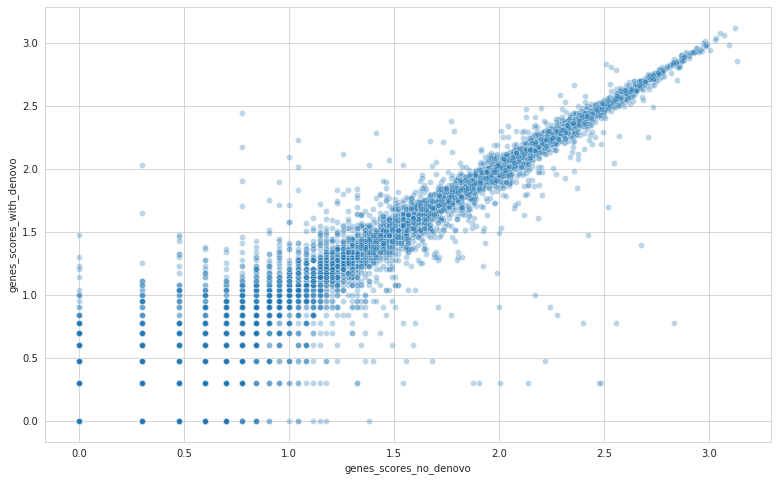

In [102]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13,8))

sns.scatterplot(x=scores_for_no_denovo_in_log10,
                y=scores_for_denovo_in_log10,
                alpha=0.3, ax=ax)

# sns.scatterplot(x=scores_for_no_denovo,
#                 y=scores_for_denovo,
#                 alpha=0.3, ax=ax)


ax.set_xlabel("genes_scores_no_denovo")
ax.set_ylabel("genes_scores_with_denovo")


In [116]:
Gene_scoreWithDeNovo_scoreNoDeNovo = namedtuple("Gene_scoreWithDeNovo_scoreNoDeNovo", "gene scoreWithDeNovo scoreWithNoDenovo delta")
genes_to_investigate = []
for index, gene in enumerate(order_of_genes_to_process):
    no_denovo_does_well_in_this_gene = scores_for_no_denovo_in_log10[index] >= 1.5
    denovo_does_badly_in_this_gene = scores_for_denovo_in_log10[index] <= 1.0
    denovo_score = scores_for_denovo[index]
    no_denovo_score = scores_for_no_denovo[index]
    delta = no_denovo_score - denovo_score
    if no_denovo_does_well_in_this_gene and denovo_does_badly_in_this_gene:
        genes_to_investigate.append(Gene_scoreWithDeNovo_scoreNoDeNovo(gene=gene, scoreWithDeNovo=denovo_score, scoreWithNoDenovo=no_denovo_score, delta=delta))
        
genes_to_investigate = sorted(genes_to_investigate, key= lambda x : x.delta, reverse=True)

output_path = Path("genes_that_nodenovo_does_well_and_denovo_does_bad.txt")
output_path.write_text("\n".join([str(_) for _ in genes_to_investigate]))

4719